In [1]:
!pip install tfa-nightly

     |████████████████████████████████| 1.1 MB 11.8 MB/s 


In [96]:
import tensorflow as tf
import os
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
  tf.config.experimental.set_memory_growth(gpu, True)
  
import tensorflow.keras as keras
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage.interpolation import rotate, shift
import PIL
from PIL import Image
from imgaug import augmenters as iaa
from skimage import util as sku
import random
from itertools import chain
from itertools import permutations
from itertools import combinations
from itertools import cycle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense, BatchNormalization, GlobalAveragePooling2D, Reshape
import json
from keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')

%load_ext tensorboard

print("Tensorflow version is: ", tf.__version__)
assert tf.__version__[0] == '2'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Tensorflow version is:  2.6.0


In [3]:
!unzip 'drive/MyDrive/A1_data.zip' -d 'A1_data'

Archive:  drive/MyDrive/A1_data.zip
  inflating: A1_data/Images.zip      
  inflating: A1_data/README.md       
  inflating: A1_data/__MACOSX/._README.md  
  inflating: A1_data/S40AR_test_data.csv  
  inflating: A1_data/__MACOSX/._S40AR_test_data.csv  
  inflating: A1_data/S40AR_train_data.csv  
  inflating: A1_data/__MACOSX/._S40AR_train_data.csv  
  inflating: A1_data/s1234567_predictions.csv  
  inflating: A1_data/__MACOSX/._s1234567_predictions.csv  


In [4]:
!unzip 'A1_data/Images.zip' -d 'A1_data'

Streaming output truncated to the last 5000 lines.
  inflating: A1_data/Images/Img_4611.jpg  
  inflating: A1_data/Images/Img_789.jpg  
  inflating: A1_data/Images/Img_7318.jpg  
  inflating: A1_data/Images/Img_6006.jpg  
  inflating: A1_data/Images/Img_9335.jpg  
  inflating: A1_data/Images/Img_1769.jpg  
  inflating: A1_data/Images/Img_8995.jpg  
  inflating: A1_data/Images/Img_6760.jpg  
  inflating: A1_data/Images/Img_9453.jpg  
  inflating: A1_data/Images/Img_3618.jpg  
  inflating: A1_data/Images/Img_4177.jpg  
  inflating: A1_data/Images/Img_5269.jpg  
  inflating: A1_data/Images/Img_2506.jpg  
  inflating: A1_data/Images/Img_4163.jpg  
  inflating: A1_data/Images/Img_2512.jpg  
  inflating: A1_data/Images/Img_8981.jpg  
  inflating: A1_data/Images/Img_6774.jpg  
  inflating: A1_data/Images/Img_9447.jpg  
  inflating: A1_data/Images/Img_8759.jpg  
  inflating: A1_data/Images/Img_6012.jpg  
  inflating: A1_data/Images/Img_9321.jpg  
  inflating: A1_data/Images/Img_2274.jpg  
  in

# Exploratory Data Analysis
## Strategy
 - Load the images and visualize a sample. Check the differences in dimensions of the images
 - Getting the minimum and maximum values for the dimensions of images 
 - Look at the basic information of the dataframe, and check for missing values
 - Checking the distribution of the action_classes and actions


In [5]:
img_dir = "A1_data/Images/"
 
data_df = pd.read_csv('A1_data/S40AR_train_data.csv')

data_df.head(5)

FileName           action             action_class
0  Img_1000.jpg  walking_the_dog  Interacting_with_animal
1  Img_1001.jpg    riding_a_bike           other_activity
2  Img_1002.jpg        gardening            domestic_work
3  Img_1008.jpg          cooking            domestic_work
4  Img_1010.jpg          jumping           other_activity

Now we can visualize the images to see if they've loaded correctly

walking_the_dog
Interacting_with_animal


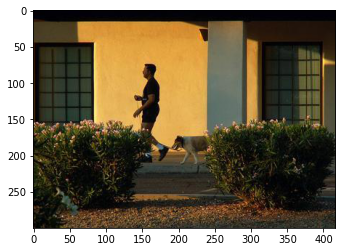

riding_a_bike
other_activity


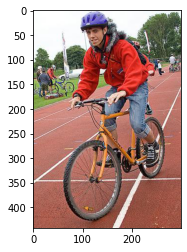

gardening
domestic_work


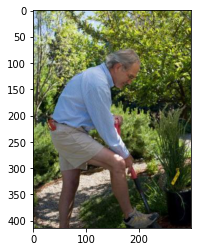

cooking
domestic_work


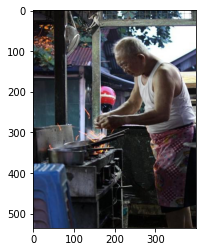

jumping
other_activity


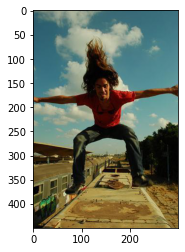

In [6]:
for i in range(5):
    img=mpimg.imread(img_dir+data_df.head(5)['FileName'][i])
    print(data_df.head(5)['action'][i])
    print(data_df.head(5)['action_class'][i])
    imgplot = plt.imshow(img)
    plt.show()

<span style="font-size:1em;">✔</span> **Observations:**
- Images loaded in correctly
- The images are all of different dimensions, resizing might be required
- Images are coloured, so there will be a 3-channel input into the model

### Getting the max and min x and y values from each image

Max X: 961
Max Y: 960
Min X: 200
Min Y: 200


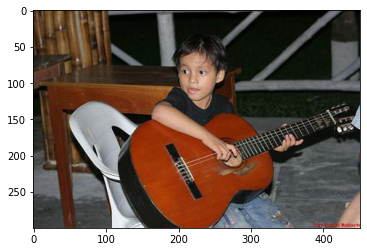

In [7]:
max_x = 0
max_y = 0
min_x = 1000
min_y = 1000

for i in range(len(data_df)):
    img=mpimg.imread(img_dir+data_df['FileName'][i])
    imgplot = plt.imshow(img)
    img_size = imgplot.get_size()
    img_x = img_size[1]
    img_y = img_size[0]
    
    if(img_x > max_x):
        max_x = img_x
    
    if(img_y > max_y):
        max_y = img_y
        
    if(img_x < min_x):
        min_x = img_x
        
    if(img_y < min_y):
        min_y = img_y
        
print("Max X: "+str(max_x))
print("Max Y: "+str(max_y))
print("Min X: "+str(min_x))
print("Min Y: "+str(min_y))

<span style="font-size:1em;">✔</span> **Observations:**

- The images vary quite greatly in dimensions, and for our model we want them all to have the same dimensions, while also retaining the characteristics of each image that makes them have an associated image. There are two major techniques for handling this, as pointed out over here - https://wandb.ai/ayush-thakur/dl-question-bank/reports/How-to-Handle-Images-of-Different-Sizes-in-a-Convolutional-Neural-Network--VmlldzoyMDk3NzQ
- Either an average size compromise or a definitive size based on the baseline model will be used

### Basic information from data frame

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3030 entries, 0 to 3029
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   FileName      3030 non-null   object
 1   action        3030 non-null   object
 2   action_class  3030 non-null   object
dtypes: object(3)
memory usage: 71.1+ KB


<span style="font-size:1em;">✔</span> **Observations:**

- There are no missing values in the dataset, so we don't have to do anything to deal with it

### Class Distribution

Now we can look at the distribution of the different action classes, and each subclass within the action classes

In [9]:
# printing out the value counts for each column
for column in data_df.columns:
    print(column + ": " + str(data_df[column].unique()))
    print(data_df[column].value_counts())
    print()

FileName: ['Img_1000.jpg' 'Img_1001.jpg' 'Img_1002.jpg' ... 'Img_987.jpg'
 'Img_988.jpg' 'Img_995.jpg']
Img_4955.jpg    1
Img_7844.jpg    1
Img_1804.jpg    1
Img_3158.jpg    1
Img_5582.jpg    1
               ..
Img_8929.jpg    1
Img_5588.jpg    1
Img_4866.jpg    1
Img_2934.jpg    1
Img_1691.jpg    1
Name: FileName, Length: 3030, dtype: int64

action: ['walking_the_dog' 'riding_a_bike' 'gardening' 'cooking' 'jumping'
 'cutting_vegetables' 'watching_TV' 'cleaning_the_floor'
 'shooting_an_arrow' 'texting_message' 'playing_violin' 'feeding_a_horse'
 'taking_photos' 'washing_dishes' 'riding_a_horse' 'rowing_a_boat'
 'playing_guitar' 'climbing' 'running' 'phoning' 'using_a_computer']
riding_a_horse        196
jumping               195
climbing              195
riding_a_bike         193
walking_the_dog       193
playing_guitar        189
cooking               188
feeding_a_horse       187
playing_violin        160
phoning               159
running               151
using_a_computer      130


<span style="font-size:1em;">✔</span> **Observations:**

- There seems to be an uneven distribution, it's worth plotting this out to visualize the differences better

Distribution of Action Class

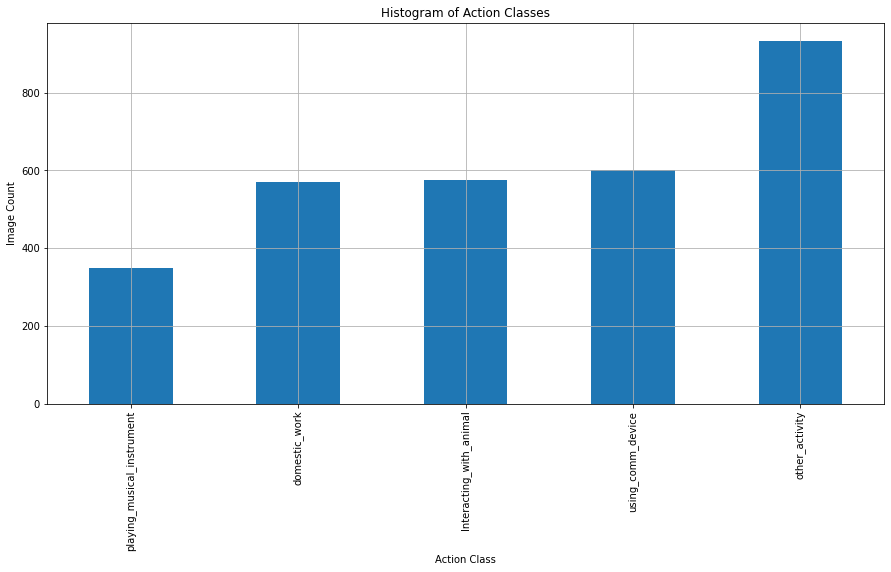

playing_musical_instrument    349
domestic_work                 570
Interacting_with_animal       576
using_comm_device             602
other_activity                933
Name: action_class, dtype: int64


In [10]:
plt.figure(figsize=(15,7))
data_df.action_class.value_counts(ascending=True).plot(kind='bar', grid=True)
plt.xlabel("Action Class")
plt.ylabel("Image Count")
plt.title("Histogram of Action Classes")
plt.show()
print(data_df.action_class.value_counts(ascending=True))

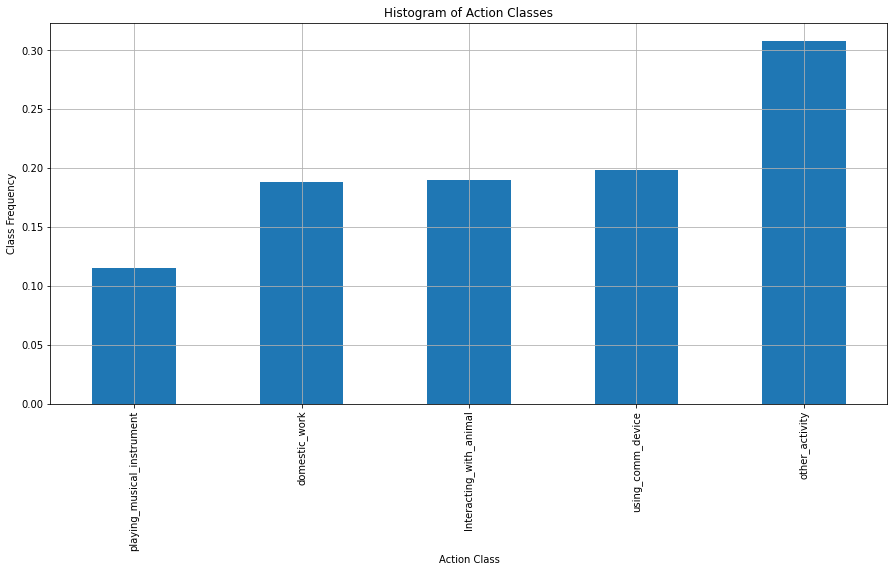

playing_musical_instrument    0.115182
domestic_work                 0.188119
Interacting_with_animal       0.190099
using_comm_device             0.198680
other_activity                0.307921
Name: action_class, dtype: float64


In [11]:
plt.figure(figsize=(15,7))
data_df.action_class.value_counts(normalize=True, ascending=True).plot(kind='bar', grid=True)
plt.xlabel("Action Class")
plt.ylabel("Class Frequency")
plt.title("Histogram of Action Classes")
plt.show()

print(data_df.action_class.value_counts(normalize=True, ascending=True))

<span style="font-size:1em;">✔</span> **Observations:**
 - There definitely is a class imbalance in this dataset, with "other_activity" having as many as 3 times the number of images as "playing musical instrument" 
 - The classes "domestic work", "interacting with animal" and "using_comm_device" are nearly evenly represented in this dataset

Distribution of Action

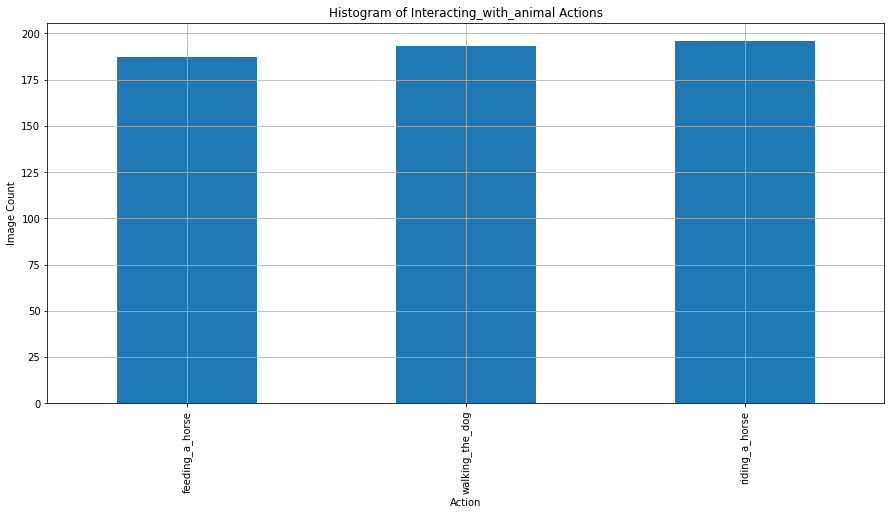

feeding_a_horse    187
walking_the_dog    193
riding_a_horse     196
Name: action, dtype: int64


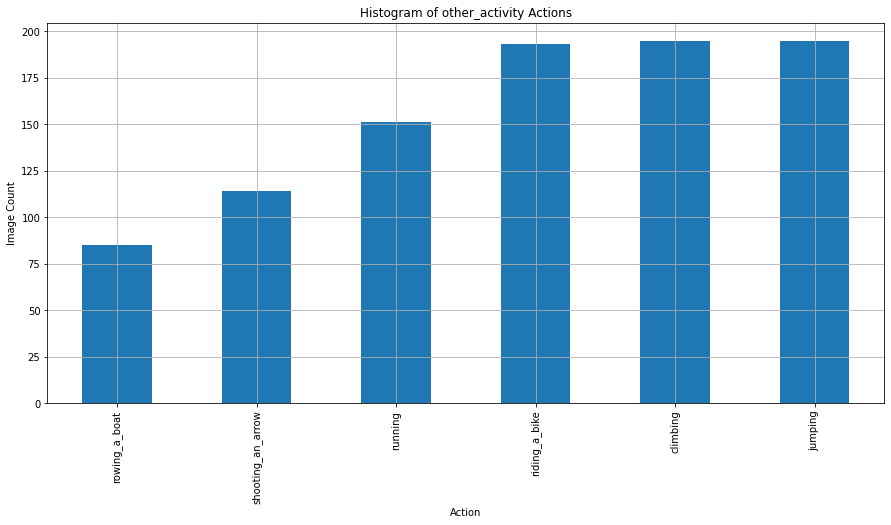

rowing_a_boat         85
shooting_an_arrow    114
running              151
riding_a_bike        193
climbing             195
jumping              195
Name: action, dtype: int64


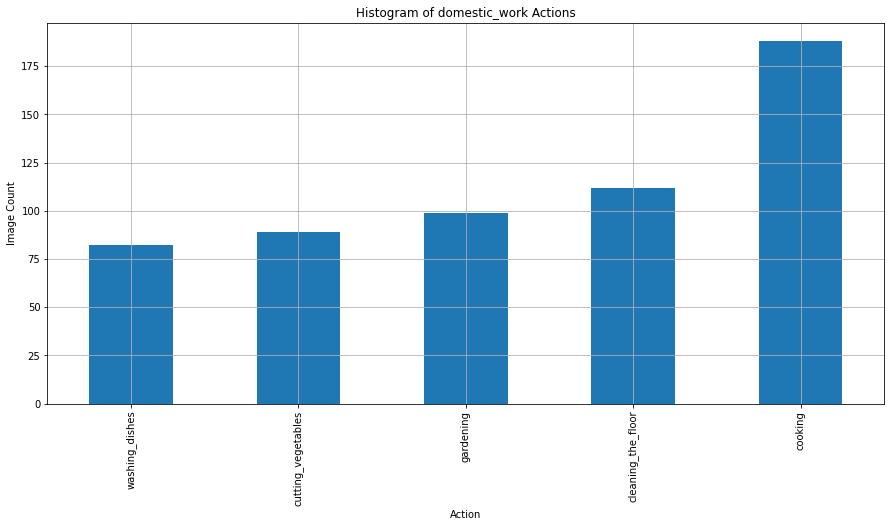

washing_dishes         82
cutting_vegetables     89
gardening              99
cleaning_the_floor    112
cooking               188
Name: action, dtype: int64


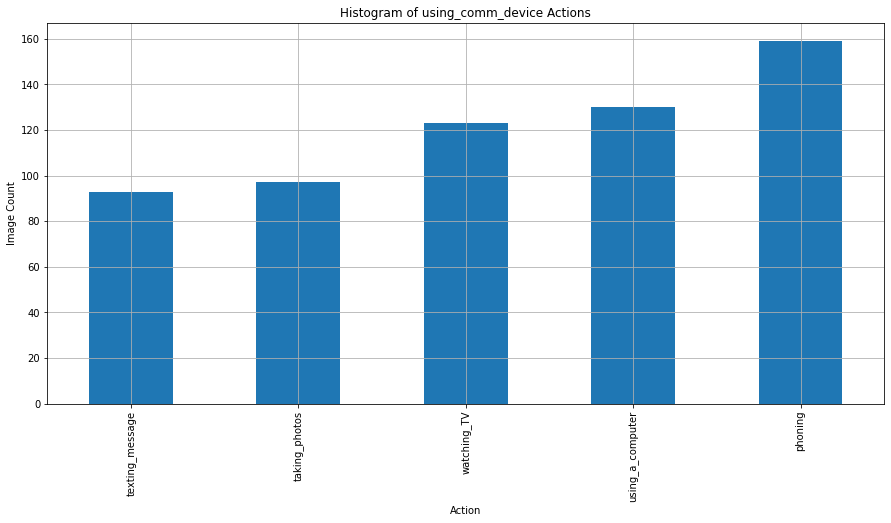

texting_message      93
taking_photos        97
watching_TV         123
using_a_computer    130
phoning             159
Name: action, dtype: int64


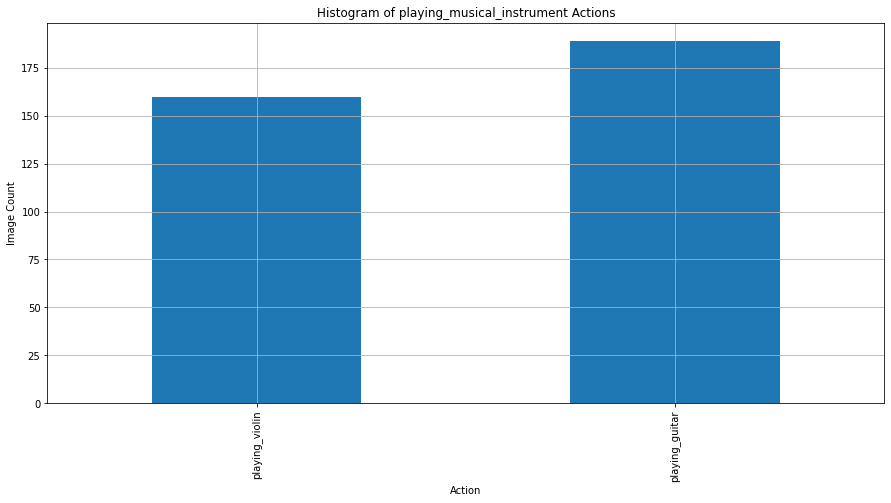

playing_violin    160
playing_guitar    189
Name: action, dtype: int64


In [12]:
for action_class in data_df['action_class'].unique():
    
    plt.figure(figsize=(15,7))
    data_df[data_df["action_class"]==action_class].action.value_counts(ascending=True).plot(kind='bar', grid=True)
    plt.xlabel("Action")
    #plt.xticks(rotation=35)
    plt.ylabel("Image Count")
    plt.title("Histogram of " + action_class + " Actions")
    plt.show()
    print(data_df[data_df["action_class"]==action_class].action.value_counts(ascending=True))

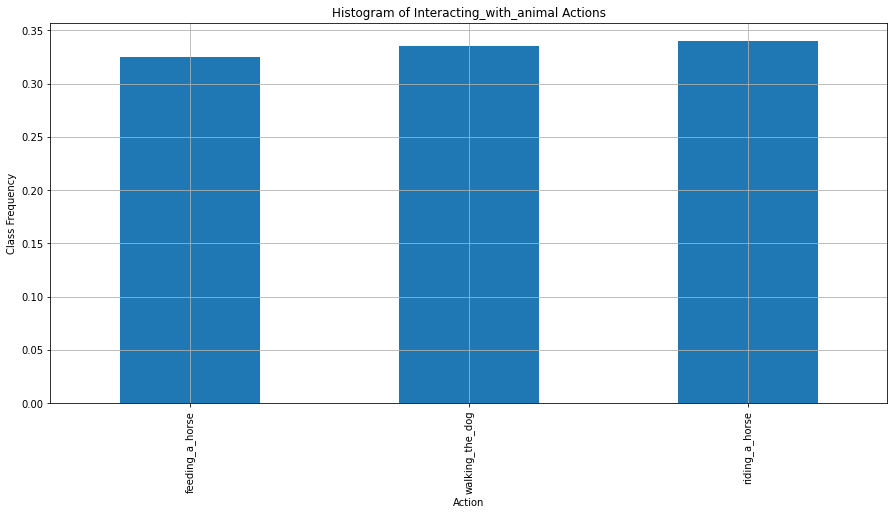

feeding_a_horse    0.324653
walking_the_dog    0.335069
riding_a_horse     0.340278
Name: action, dtype: float64


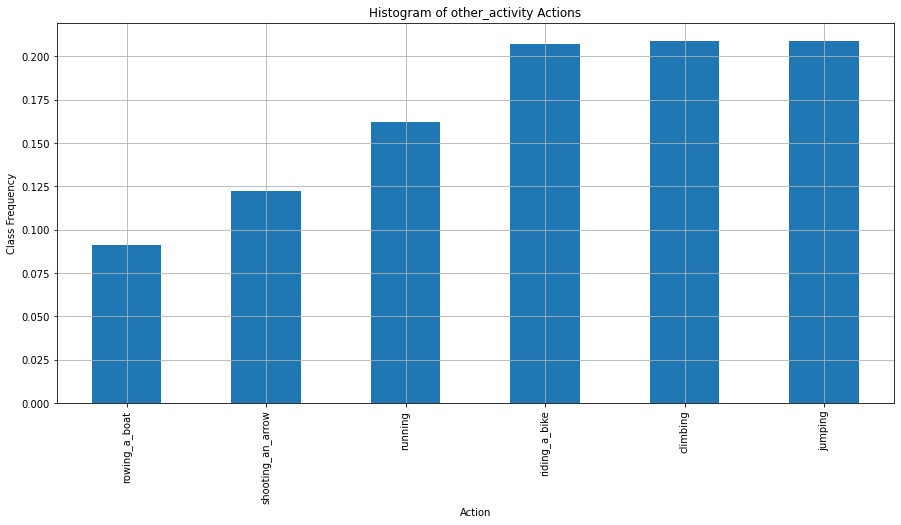

rowing_a_boat        0.091104
shooting_an_arrow    0.122186
running              0.161844
riding_a_bike        0.206860
climbing             0.209003
jumping              0.209003
Name: action, dtype: float64


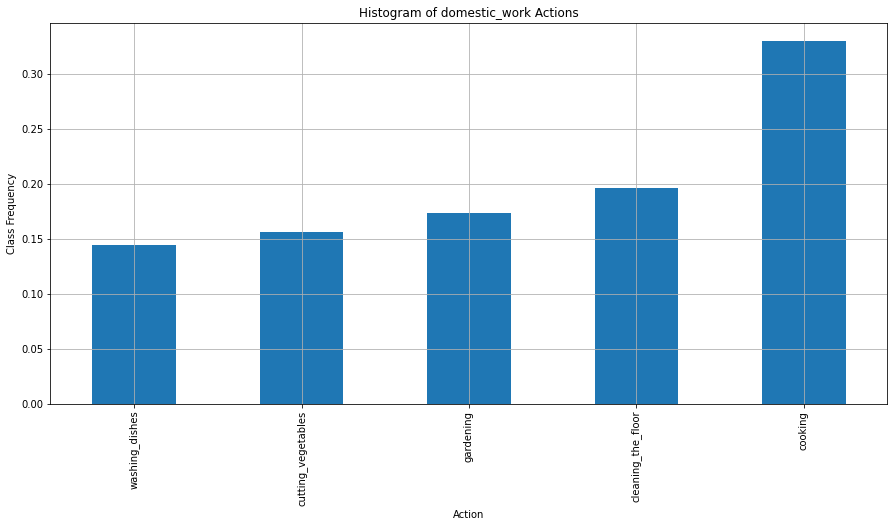

washing_dishes        0.143860
cutting_vegetables    0.156140
gardening             0.173684
cleaning_the_floor    0.196491
cooking               0.329825
Name: action, dtype: float64


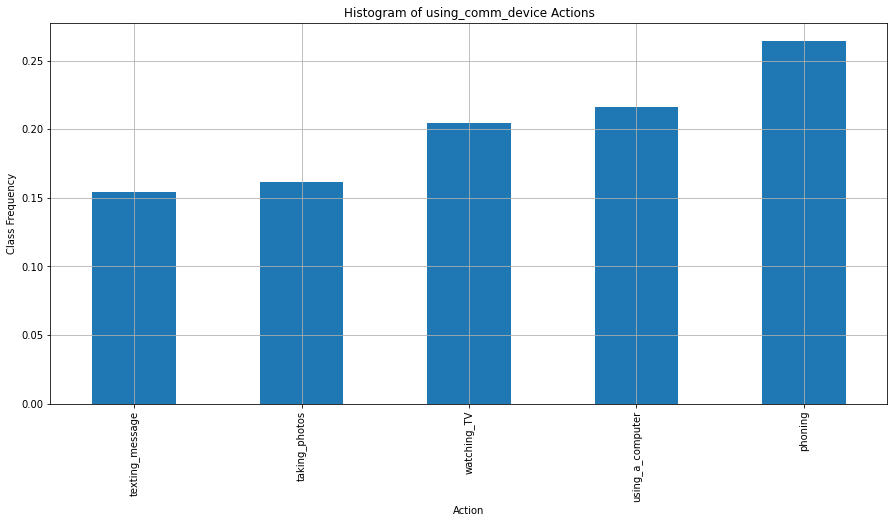

texting_message     0.154485
taking_photos       0.161130
watching_TV         0.204319
using_a_computer    0.215947
phoning             0.264120
Name: action, dtype: float64


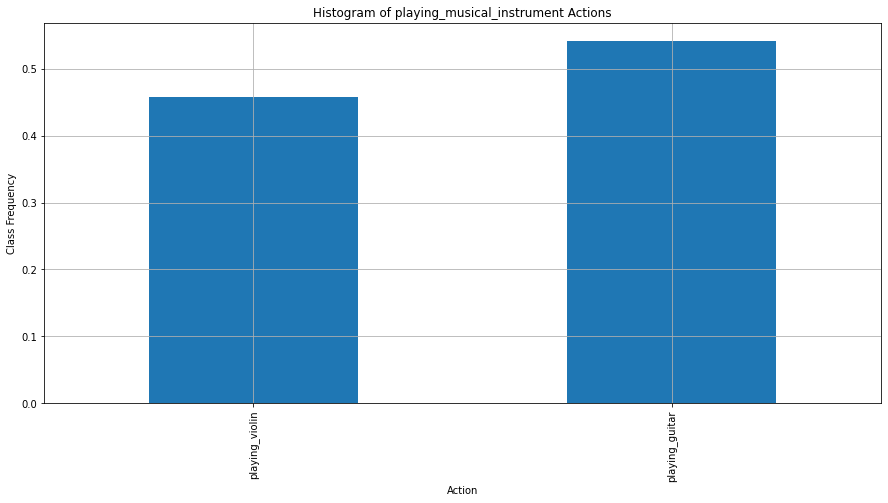

playing_violin    0.458453
playing_guitar    0.541547
Name: action, dtype: float64


In [13]:
for action_class in data_df['action_class'].unique():
    
    plt.figure(figsize=(15,7))
    data_df[data_df["action_class"]==action_class].action.value_counts(normalize = True, ascending=True).plot(kind='bar', grid=True)
    plt.xlabel("Action")
    #plt.xticks(rotation=35)
    plt.ylabel("Class Frequency")
    plt.title("Histogram of " + action_class + " Actions")
    plt.show()
    print(data_df[data_df["action_class"]==action_class].action.value_counts(normalize= True, ascending=True))

<span style="font-size:1em;">✔</span> **Observations:**
 - Actions of action classes "playing_musical_instrument" and "interacting_with_animal" are well balanced
 - The other 3 action classes have a lot of imbalance with their sub actions 

### Performance metric choice
 - action_class: **Accuracy**. Even though there is an imbalance in class distribution, this is something we can accommodate for with data augmentation. Moreover, if we consider the distribution ignoring "other_activity", it is not too imbalanced. "other_activity" is a generic action_class for arguably a more diverse set of actions than the other action_classes. Thus, the standard accuracy metric should be good enough. 
 - action: **Top 5 Categorical Accuracy**. Chosen because there are 21 classes in total, with a wide variety of different actions, that can sometimes be interpreted differently. For example, "cooking", "washing dishes", and "cutting vegetables" are 3 activites that tend to have the person doing them in a similar posture. Our deep learning model may interpret this posture to be the primary determinant of classifying these. Moreover, sometimes there is overlap in the images themselves. For example, a person may be cutting vegetables, but have the stove on with food cooking and dishes in the sink all simultaneously. This can confuse the model, so having a "top 5" seems more appropriate.

# Data Loader
## Strategy
 - Resize all the images to a unified size, and save to a new dataframe
 - Take a sample of images, and try different augmentations on them, visualizing all the augmentations
 - Determine the parameters (or range of parameters) for each augmentation within which the image is still usable
 - Write a function to generate permutations and combinations of each of the augmentations for each image, preserving the label

In [14]:
data_df

FileName           action                action_class
0     Img_1000.jpg  walking_the_dog     Interacting_with_animal
1     Img_1001.jpg    riding_a_bike              other_activity
2     Img_1002.jpg        gardening               domestic_work
3     Img_1008.jpg          cooking               domestic_work
4     Img_1010.jpg          jumping              other_activity
...            ...              ...                         ...
3025   Img_977.jpg  texting_message           using_comm_device
3026   Img_980.jpg  feeding_a_horse     Interacting_with_animal
3027   Img_987.jpg    riding_a_bike              other_activity
3028   Img_988.jpg          jumping              other_activity
3029   Img_995.jpg   playing_guitar  playing_musical_instrument

[3030 rows x 3 columns]

### Image Resizing

 - 224x224 was chosen as it is a common image size to input for images that convey more complex data 
 - Furthermore, upsizing smaller images to a higher resolution might make them lose some details due to fuzziness
 - Higher resolution images will also require a lot more computational time for network


In [15]:
# UNCOMMENT THE LINE BELOW TO CREATE THE NEW DIRECTORY
!mkdir "images_scaled"
for i in range(len(data_df)):
    img=mpimg.imread(img_dir+data_df['FileName'][i])
    #imgplot = plt.imshow(img)
    image_scaled = tf.image.convert_image_dtype(img, tf.float32)
    image_scaled = tf.image.resize(image_scaled, (224, 224))
    
    
    tf.keras.preprocessing.image.save_img("images_scaled/"+data_df['FileName'][i], image_scaled)

In [16]:
data_df.action = pd.Categorical(data_df.action)
data_df["action_num"] = data_df.action.cat.codes

data_df.action_class = pd.Categorical(data_df.action_class)
data_df["action_class_num"] = data_df.action_class.cat.codes

data_df["FileName_scaled"] = "images_scaled/" + data_df['FileName'] 


In [17]:
data_df

FileName  ...             FileName_scaled
0     Img_1000.jpg  ...  images_scaled/Img_1000.jpg
1     Img_1001.jpg  ...  images_scaled/Img_1001.jpg
2     Img_1002.jpg  ...  images_scaled/Img_1002.jpg
3     Img_1008.jpg  ...  images_scaled/Img_1008.jpg
4     Img_1010.jpg  ...  images_scaled/Img_1010.jpg
...            ...  ...                         ...
3025   Img_977.jpg  ...   images_scaled/Img_977.jpg
3026   Img_980.jpg  ...   images_scaled/Img_980.jpg
3027   Img_987.jpg  ...   images_scaled/Img_987.jpg
3028   Img_988.jpg  ...   images_scaled/Img_988.jpg
3029   Img_995.jpg  ...   images_scaled/Img_995.jpg

[3030 rows x 6 columns]

### Image augmentations
#### Strategy
- The best parameters were picked from each observation, and then combinations of all of them were looked at on images to see if the images still held up to being what theyre supposed to look like as per the label

#### Horizontal/Vertical flipping

walking_the_dog
Interacting_with_animal


<Figure size 432x288 with 0 Axes>

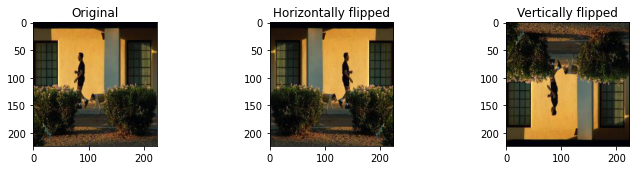

-------------------------------------------------------------------------------------------------------------------
riding_a_bike
other_activity


<Figure size 432x288 with 0 Axes>

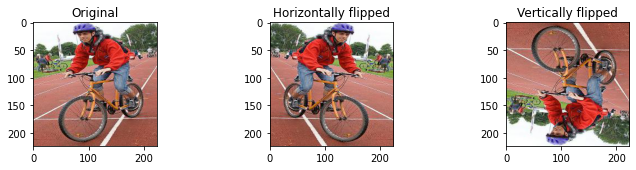

-------------------------------------------------------------------------------------------------------------------
gardening
domestic_work


<Figure size 432x288 with 0 Axes>

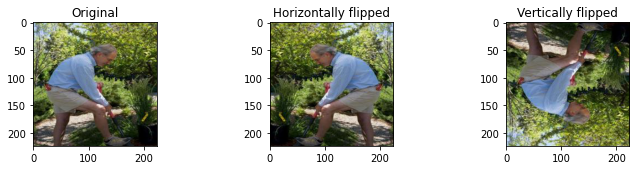

-------------------------------------------------------------------------------------------------------------------
cooking
domestic_work


<Figure size 432x288 with 0 Axes>

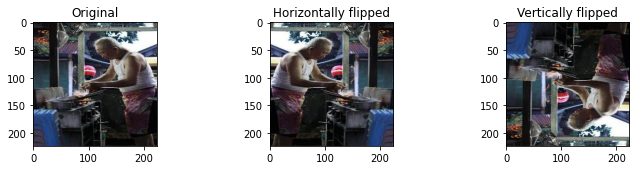

-------------------------------------------------------------------------------------------------------------------
jumping
other_activity


<Figure size 432x288 with 0 Axes>

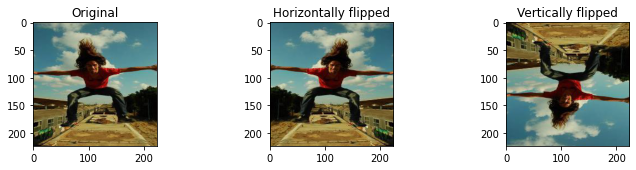

-------------------------------------------------------------------------------------------------------------------


In [18]:
for i in range(5):
    #plt.subplots(1,3)
    plt.figure(1)
    plt.figure(figsize=(12,5))
    plt.subplot(231)
    plt.title("Original")
    img=mpimg.imread(data_df.head(5)['FileName_scaled'][i])
    print(data_df.head(5)['action'][i])
    print(data_df.head(5)['action_class'][i])
    plt.imshow(img)
    
    #plt.show()
   
    #Horizontally flipped
    hflip= iaa.Fliplr(p=1.0)
    hflipped_image= hflip.augment_image(img)

    #Vertically flipped
    vflip= iaa.Flipud(p=1.0) 
    vflipped_image= vflip.augment_image(img)
    
    
    plt.subplot(232)
    plt.title("Horizontally flipped")
    plt.imshow(hflipped_image)
    plt.subplot(233)
    plt.imshow(vflipped_image)
    plt.title("Vertically flipped")
    plt.show()
    
    print("-------------------------------------------------------------------------------------------------------------------")
    
    #plt.show()


#### Rotation

walking_the_dog
Interacting_with_animal


<Figure size 432x288 with 0 Axes>

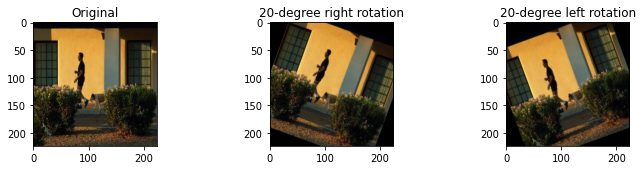

-------------------------------------------------------------------------------------------------------------------
riding_a_bike
other_activity


<Figure size 432x288 with 0 Axes>

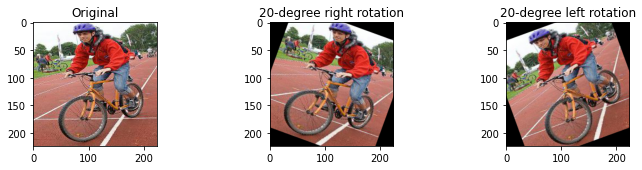

-------------------------------------------------------------------------------------------------------------------
gardening
domestic_work


<Figure size 432x288 with 0 Axes>

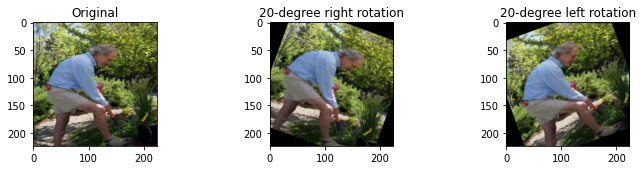

-------------------------------------------------------------------------------------------------------------------
cooking
domestic_work


<Figure size 432x288 with 0 Axes>

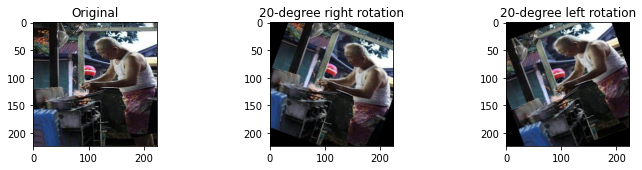

-------------------------------------------------------------------------------------------------------------------
jumping
other_activity


<Figure size 432x288 with 0 Axes>

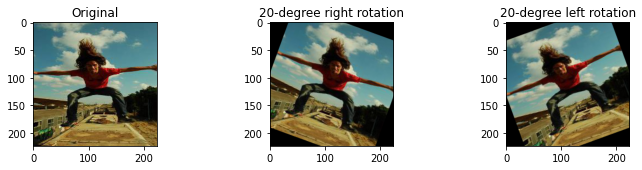

-------------------------------------------------------------------------------------------------------------------


In [19]:
rotation_degree = 20
for i in range(5):
    #plt.subplots(1,3)
    plt.figure(1)
    plt.figure(figsize=(12,5))
    plt.subplot(231)
    plt.title("Original")
    img=mpimg.imread(data_df.head(5)['FileName_scaled'][i])
    print(data_df.head(5)['action'][i])
    print(data_df.head(5)['action_class'][i])
    plt.imshow(img)
    
    #plt.show()
   
    # clockwise rotation
    rot = iaa.Affine(rotate=(rotation_degree,rotation_degree))
    rot_clockwise_image_right = rot.augment_image(img)

    # clockwise rotation
    rot2 = iaa.Affine(rotate=(-rotation_degree,-rotation_degree))
    rot_clockwise_image_left = rot2.augment_image(img)
    
    
    plt.subplot(232)
    plt.title(str(rotation_degree)+"-degree right rotation")
    plt.imshow(rot_clockwise_image_right)
    
    plt.subplot(233)
    plt.imshow(rot_clockwise_image_left)
    plt.title(str(rotation_degree)+"-degree left rotation")
    plt.show()
    
    print("-------------------------------------------------------------------------------------------------------------------")
    
    #plt.show()


#### Image cropping

walking_the_dog
Interacting_with_animal


<Figure size 432x288 with 0 Axes>

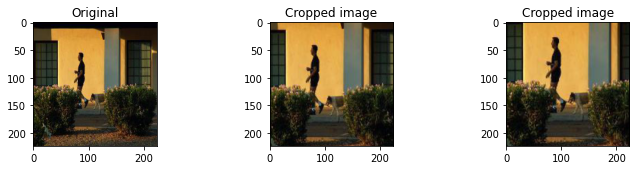

-------------------------------------------------------------------------------------------------------------------
riding_a_bike
other_activity


<Figure size 432x288 with 0 Axes>

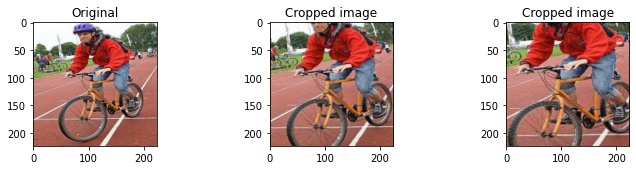

-------------------------------------------------------------------------------------------------------------------
gardening
domestic_work


<Figure size 432x288 with 0 Axes>

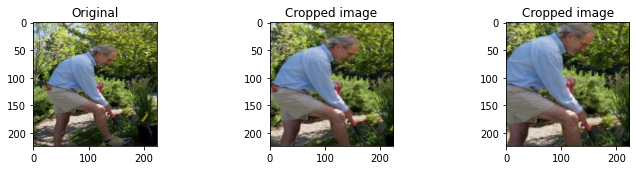

-------------------------------------------------------------------------------------------------------------------
cooking
domestic_work


<Figure size 432x288 with 0 Axes>

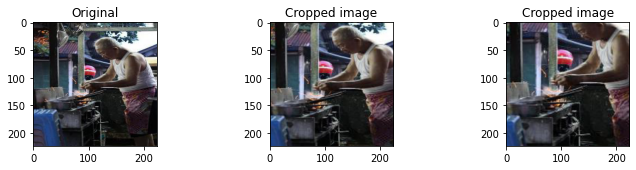

-------------------------------------------------------------------------------------------------------------------
jumping
other_activity


<Figure size 432x288 with 0 Axes>

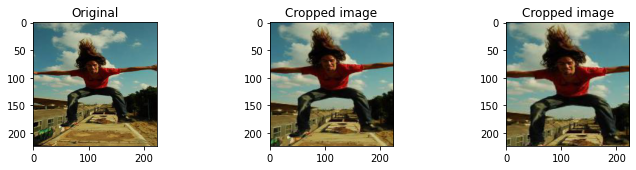

-------------------------------------------------------------------------------------------------------------------


In [20]:


for i in range(5):
    
    
    plt.figure(1)
    plt.figure(figsize=(12,5))
    plt.subplot(231)
    plt.title("Original")
    img=mpimg.imread(data_df.head(5)['FileName_scaled'][i])
    print(data_df.head(5)['action'][i])
    print(data_df.head(5)['action_class'][i])
    plt.imshow(img)
    
    crop = iaa.Crop(percent=(0.1, 0.1)) # crop image
    crop_image1=crop.augment_image(img)
    
    crop = iaa.Crop(percent=(0.1, 0.2)) # crop image
    crop_image2=crop.augment_image(img)

    
    plt.subplot(232)
    plt.title("Cropped image")
    plt.imshow(crop_image1)
    
    plt.subplot(233)
    plt.title("Cropped image")
    plt.imshow(crop_image2)
    
    plt.show()
    
    print("-------------------------------------------------------------------------------------------------------------------")
    
    #plt.show()

    



#### Gamma adjustment (brightening and darkening)

walking_the_dog
Interacting_with_animal


<Figure size 432x288 with 0 Axes>

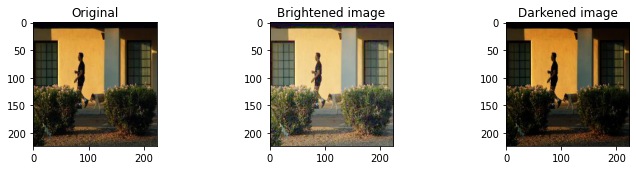

-------------------------------------------------------------------------------------------------------------------
riding_a_bike
other_activity


<Figure size 432x288 with 0 Axes>

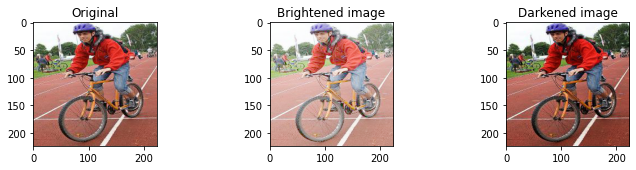

-------------------------------------------------------------------------------------------------------------------
gardening
domestic_work


<Figure size 432x288 with 0 Axes>

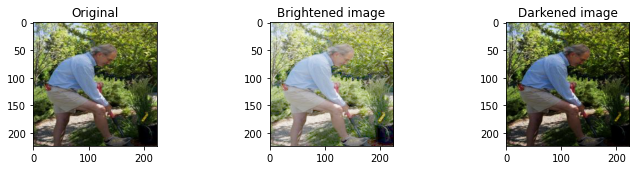

-------------------------------------------------------------------------------------------------------------------
cooking
domestic_work


<Figure size 432x288 with 0 Axes>

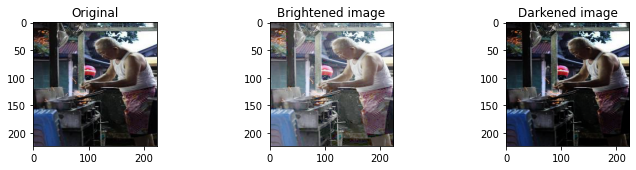

-------------------------------------------------------------------------------------------------------------------
jumping
other_activity


<Figure size 432x288 with 0 Axes>

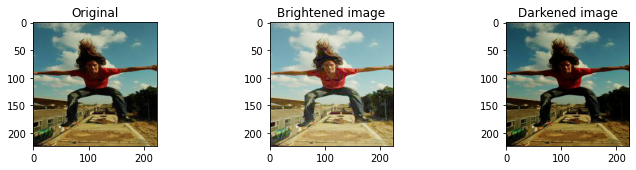

-------------------------------------------------------------------------------------------------------------------


In [21]:


for i in range(5):
    
    
    plt.figure(1)
    plt.figure(figsize=(12,5))
    plt.subplot(231)
    plt.title("Original")
    img=mpimg.imread(data_df.head(5)['FileName_scaled'][i])
    print(data_df.head(5)['action'][i])
    print(data_df.head(5)['action_class'][i])
    plt.imshow(img)
    
   # bright
    contrast1=iaa.GammaContrast(gamma=0.5)
    brightened_image = contrast1.augment_image(img)

    #dark
    contrast2=iaa.GammaContrast(gamma=1.3)
    darkened_image = contrast2.augment_image(img)

    
    plt.subplot(232)
    plt.title("Brightened image")
    plt.imshow(brightened_image)
    
    plt.subplot(233)
    plt.title("Darkened image")
    plt.imshow(darkened_image)
    
    plt.show()
    
    print("-------------------------------------------------------------------------------------------------------------------")
    
    #plt.show()

    



#### Adding random noise

walking_the_dog
Interacting_with_animal


<Figure size 432x288 with 0 Axes>

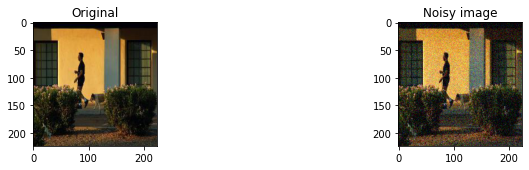

-------------------------------------------------------------------------------------------------------------------
riding_a_bike
other_activity


<Figure size 432x288 with 0 Axes>

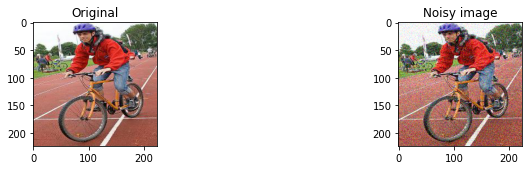

-------------------------------------------------------------------------------------------------------------------
gardening
domestic_work


<Figure size 432x288 with 0 Axes>

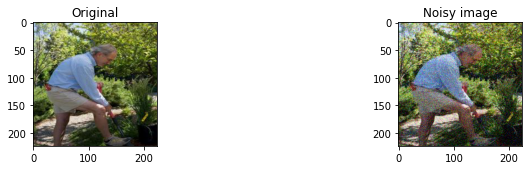

-------------------------------------------------------------------------------------------------------------------
cooking
domestic_work


<Figure size 432x288 with 0 Axes>

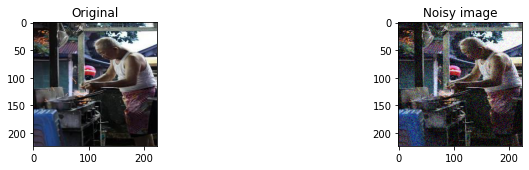

-------------------------------------------------------------------------------------------------------------------
jumping
other_activity


<Figure size 432x288 with 0 Axes>

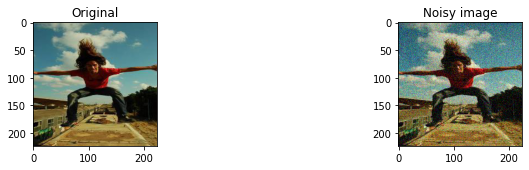

-------------------------------------------------------------------------------------------------------------------


In [22]:


for i in range(5):
    
    
    plt.figure(1)
    plt.figure(figsize=(12,5))
    plt.subplot(221)
    plt.title("Original")
    img=mpimg.imread(data_df.head(5)['FileName_scaled'][i])
    print(data_df.head(5)['action'][i])
    print(data_df.head(5)['action_class'][i])
    plt.imshow(img)
    

    noisy_image= sku.random_noise(img)
    
    
    plt.subplot(222)
    plt.title("Noisy image")
    plt.imshow(noisy_image)
    
    plt.show()
    
    print("-------------------------------------------------------------------------------------------------------------------")
    
    #plt.show()

    



#### Trying random combinations together


walking_the_dog
Interacting_with_animal


<Figure size 432x288 with 0 Axes>

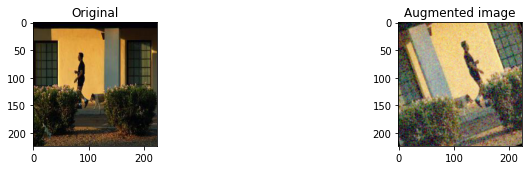

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------------------------------------------------------------------------------------
riding_a_bike
other_activity


<Figure size 432x288 with 0 Axes>

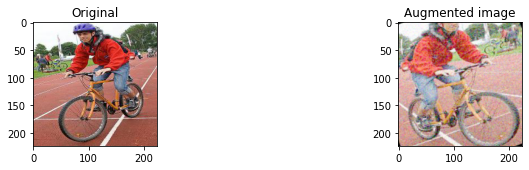

-------------------------------------------------------------------------------------------------------------------
gardening
domestic_work


<Figure size 432x288 with 0 Axes>

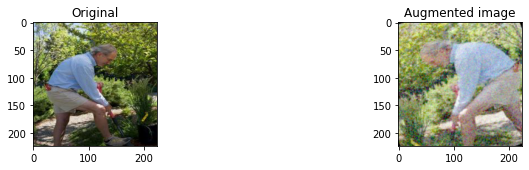

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------------------------------------------------------------------------------------
cooking
domestic_work


<Figure size 432x288 with 0 Axes>

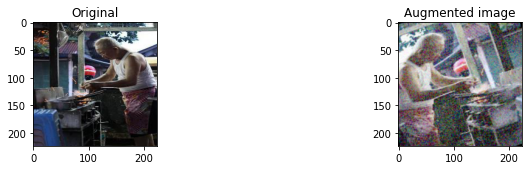

-------------------------------------------------------------------------------------------------------------------
jumping
other_activity


<Figure size 432x288 with 0 Axes>

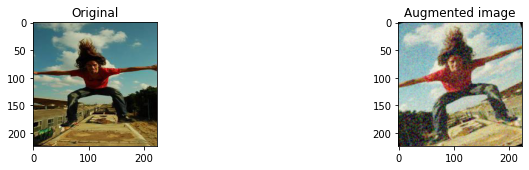

-------------------------------------------------------------------------------------------------------------------


In [23]:


for i in range(5):
    
    
    plt.figure(1)
    plt.figure(figsize=(12,5))
    plt.subplot(221)
    plt.title("Original")
    img=mpimg.imread(data_df.head(5)['FileName_scaled'][i])
    print(data_df.head(5)['action'][i])
    print(data_df.head(5)['action_class'][i])
    plt.imshow(img)
    
    # add noise
    noisy_image= sku.random_noise(img)
    
    # brighten
    contrast1=iaa.GammaContrast(gamma=0.5)
    brightened_image = contrast1.augment_image(noisy_image)
    
    # rotate
    rot = iaa.Affine(rotate=(rotation_degree,rotation_degree))
    rot_clockwise_image_right = rot.augment_image(brightened_image)
    
    # crop
    crop = iaa.Crop(percent=(0.1, 0.1)) 
    crop_image1=crop.augment_image(rot_clockwise_image_right)
    
    # flip horizontally
    hflip= iaa.Fliplr(p=1.0)
    hflipped_image= hflip.augment_image(crop_image1)
    
    plt.subplot(222)
    plt.title("Augmented image")
    plt.imshow(hflipped_image)
    
    plt.show()
    
    print("-------------------------------------------------------------------------------------------------------------------")
    
    #plt.show()

    



<span style="font-size:1em;">✔</span> **Observations:**
 - The images seem to retain their essence in terms of their classification label, while still being different to the original, as we want the augmentations to be

### Putting it all together

In [24]:
data_df

FileName  ...             FileName_scaled
0     Img_1000.jpg  ...  images_scaled/Img_1000.jpg
1     Img_1001.jpg  ...  images_scaled/Img_1001.jpg
2     Img_1002.jpg  ...  images_scaled/Img_1002.jpg
3     Img_1008.jpg  ...  images_scaled/Img_1008.jpg
4     Img_1010.jpg  ...  images_scaled/Img_1010.jpg
...            ...  ...                         ...
3025   Img_977.jpg  ...   images_scaled/Img_977.jpg
3026   Img_980.jpg  ...   images_scaled/Img_980.jpg
3027   Img_987.jpg  ...   images_scaled/Img_987.jpg
3028   Img_988.jpg  ...   images_scaled/Img_988.jpg
3029   Img_995.jpg  ...   images_scaled/Img_995.jpg

[3030 rows x 6 columns]

First we split the data into train, test, and validation sets

In [25]:
train_data_df, test_data_df = train_test_split(data_df, test_size=0.25, random_state=777, shuffle=True)
train_data_df, val_data_df = train_test_split(train_data_df, test_size = 0.25, random_state = 888, shuffle = True)

In [26]:
train_data_df

FileName  ...             FileName_scaled
1494  Img_5261.jpg  ...  images_scaled/Img_5261.jpg
483   Img_2455.jpg  ...  images_scaled/Img_2455.jpg
1052  Img_4043.jpg  ...  images_scaled/Img_4043.jpg
2695  Img_8659.jpg  ...  images_scaled/Img_8659.jpg
2702   Img_868.jpg  ...   images_scaled/Img_868.jpg
...            ...  ...                         ...
1804  Img_6122.jpg  ...  images_scaled/Img_6122.jpg
2606  Img_8406.jpg  ...  images_scaled/Img_8406.jpg
33    Img_1098.jpg  ...  images_scaled/Img_1098.jpg
1635  Img_5642.jpg  ...  images_scaled/Img_5642.jpg
687   Img_2982.jpg  ...  images_scaled/Img_2982.jpg

[1704 rows x 6 columns]

In [27]:
val_data_df

FileName  ...             FileName_scaled
2704  Img_8683.jpg  ...  images_scaled/Img_8683.jpg
1095   Img_419.jpg  ...   images_scaled/Img_419.jpg
2969  Img_9398.jpg  ...  images_scaled/Img_9398.jpg
1316  Img_4789.jpg  ...  images_scaled/Img_4789.jpg
881   Img_3555.jpg  ...  images_scaled/Img_3555.jpg
...            ...  ...                         ...
2486   Img_808.jpg  ...   images_scaled/Img_808.jpg
2175  Img_7183.jpg  ...  images_scaled/Img_7183.jpg
551   Img_2611.jpg  ...  images_scaled/Img_2611.jpg
2666  Img_8559.jpg  ...  images_scaled/Img_8559.jpg
2964  Img_9389.jpg  ...  images_scaled/Img_9389.jpg

[568 rows x 6 columns]

In [28]:
test_data_df

FileName  ...             FileName_scaled
535    Img_257.jpg  ...   images_scaled/Img_257.jpg
1369  Img_4929.jpg  ...  images_scaled/Img_4929.jpg
1171  Img_4372.jpg  ...  images_scaled/Img_4372.jpg
2921  Img_9279.jpg  ...  images_scaled/Img_9279.jpg
736   Img_3148.jpg  ...  images_scaled/Img_3148.jpg
...            ...  ...                         ...
1076  Img_4112.jpg  ...  images_scaled/Img_4112.jpg
545   Img_2596.jpg  ...  images_scaled/Img_2596.jpg
1645  Img_5672.jpg  ...  images_scaled/Img_5672.jpg
894   Img_3588.jpg  ...  images_scaled/Img_3588.jpg
1387  Img_4963.jpg  ...  images_scaled/Img_4963.jpg

[758 rows x 6 columns]

In [29]:
augmentations = ['hflip', 'rotate', 'crop', 'gamma', 'noise']
augmentation_combinations = list(chain(*[combinations(augmentations, i+1) for i in range(len(augmentations))]))

In [30]:
augmentation_combinations

[('hflip',),
 ('rotate',),
 ('crop',),
 ('gamma',),
 ('noise',),
 ('hflip', 'rotate'),
 ('hflip', 'crop'),
 ('hflip', 'gamma'),
 ('hflip', 'noise'),
 ('rotate', 'crop'),
 ('rotate', 'gamma'),
 ('rotate', 'noise'),
 ('crop', 'gamma'),
 ('crop', 'noise'),
 ('gamma', 'noise'),
 ('hflip', 'rotate', 'crop'),
 ('hflip', 'rotate', 'gamma'),
 ('hflip', 'rotate', 'noise'),
 ('hflip', 'crop', 'gamma'),
 ('hflip', 'crop', 'noise'),
 ('hflip', 'gamma', 'noise'),
 ('rotate', 'crop', 'gamma'),
 ('rotate', 'crop', 'noise'),
 ('rotate', 'gamma', 'noise'),
 ('crop', 'gamma', 'noise'),
 ('hflip', 'rotate', 'crop', 'gamma'),
 ('hflip', 'rotate', 'crop', 'noise'),
 ('hflip', 'rotate', 'gamma', 'noise'),
 ('hflip', 'crop', 'gamma', 'noise'),
 ('rotate', 'crop', 'gamma', 'noise'),
 ('hflip', 'rotate', 'crop', 'gamma', 'noise')]

<span style="font-size:1em;">✔</span> **Observations:**
 - There are 32 variations for each image, excluding the original

#### Writing the generator
For this assignment I wrote a custom data generator, with a modified data loading mechanism from the class in the week 5 lab, as well as the custom generator found [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

The data generator has the capability to augment the images, as well as load the images with the two classes, to be fed into our Mutli-Task learning model. 

In [66]:
class DataGenerator(keras.utils.Sequence):
    
    # Initializer 
    def __init__(self, data_frame, batch_size = 32, dim = (224, 224, 3, 1), n_channels = 1, 
                 shuffle = True, create_folder = False, 
                 augment = False, file_name = '',  data_mean=0, data_std=1, image_column = "FileName"):
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.create_folder = create_folder
        self.file_name = file_name
        self.augment = augment
        self.dim = dim
        self.n_channels = n_channels
        self.data_frame = data_frame
        self.image_column = image_column

        # if the data is to be augmented, we call the augment function
        if self.augment == True:
            self.data_frame = self.__augment()
        # otherwise read the dataframe as is
        else:
            self.data_frame = data_frame
        
        # We have 2 labels since we're going to be doing multi-class learning 
        self.action_class_label = data_frame['action_class_num'].values.tolist() #y1
        self.action_class_ids = np.arange(len(self.action_class_label)).tolist()
        
        self.action_label = data_frame['action_num'].values.tolist() #y2
        self.action_ids = np.arange(len(self.action_label)).tolist()
        
        # Data normalization parameters
        self.data_mean = data_mean
        self.data_std = data_std
        
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.action_class_ids) / self.batch_size))
        
    def __augment(self):
        'Augmentation function'

        rows_list = []
        if self.create_folder == True:
            !mkdir "images_augmented"
        
        # Augmentation parameters 
        rotation_degree = 20 
        augmentations = ['hflip', 'rotate', 'crop', 'gamma', 'noise']
        augmentation_combinations = list(chain(*[combinations(augmentations, i+1) for i in range(len(augmentations))]))
        
        for index, row in self.data_frame.iterrows():
            
            # Reading in the image file
            img=mpimg.imread(row['FileName_scaled'])
            og_filename = "images_augmented/"+ (row['FileName_scaled'][14:])
            dict_line = {"FileName": og_filename, "action":row["action"], "action_class":row["action_class"]}
            rows_list.append(dict_line)
            tf.keras.preprocessing.image.save_img(og_filename, img)

            # Looping over each augmentation combination from above, and applying the augmentation(s)
            for augmentation in augmentation_combinations:

                img=mpimg.imread(row['FileName_scaled'])

                # Horizontal flip
                if 'hflip' in augmentation:

                    hflip = iaa.Fliplr(p=1.0)
                    img = hflip.augment_image(img)

                # Rotation
                if 'rotate' in augmentation:

                    # randomly selectes clockwise or anti-clockwise
                    rotation_orientation = random.choice([(rotation_degree,rotation_degree), (-rotation_degree,-rotation_degree)])
                    rot = iaa.Affine(rotate=rotation_orientation)
                    img = rot.augment_image(img)
                
                # Cropping
                if 'crop' in augmentation:

                    crop = iaa.Crop(percent=(0.1, 0.1))
                    img = crop.augment_image(img)

                # Gamme
                if 'gamma' in augmentation: 

                    # randomly selects brightening or darkening
                    gamma = random.choice([0.5, 1.3])
                    contrast_brighten = iaa.GammaContrast(gamma=gamma)
                    img = contrast_brighten.augment_image(img)
                
                # Adding noise
                if 'noise' in augmentation: 

                    img = sku.random_noise(img)

                # Saving the augmented image
                augmented_filename = "images_augmented/"+ (row['FileName_scaled'][14:-4])+"_" + str(augmentation)+".jpg"
                tf.keras.preprocessing.image.save_img(augmented_filename, img)
                dict_line = {"FileName": augmented_filename, "action":row["action"], "action_class":row["action_class"]}
                rows_list.append(dict_line)
        
        # Creating a new dataframe from the augmented images and saving it
        augmented_df = pd.DataFrame(rows_list)
        augmented_df.to_csv(self.file_name, index = False)
        
        # Changing the dataframe's labels to categorical numbers
        augmented_df.action = pd.Categorical(augmented_df.action)
        augmented_df["action_num"] = augmented_df.action.cat.codes

        augmented_df.action_class = pd.Categorical(augmented_df.action_class)
        augmented_df["action_class_num"] = augmented_df.action_class.cat.codes
        
        return augmented_df
    
    
    def __getitem__(self, index):
        'Generate one batch of data for the given index'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        data_ids_temp = [self.action_class_ids[k] for k in indexes]
        
        action_class_label_temp = [self.action_class_label[k] for k in indexes]
        action_label_temp = [self.action_label[k] for k in indexes]
        
        # Generate data
        X, [action_class, action] = self.__data_generation(data_ids_temp, action_class_label_temp, action_label_temp)
        
        return X, [keras.utils.to_categorical(action_class, num_classes=5), keras.utils.to_categorical(action, num_classes=21)]
        #return X, [action_class, action]
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.action_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
        
    def __data_generation(self, data_ids_temp, action_class_label_temp, action_label_temp):
        'Generates data containing batch_size samples' 

        # Initialization
        X = np.empty((self.batch_size, *self.dim))#, self.n_channels))
        action_class = np.empty((self.batch_size), dtype=int)
        action = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, ids in enumerate(data_ids_temp):
            
            X[i,] = self.__read_data_instance(data_ids_temp[i])
            action_class[i] = action_class_label_temp[i]
            action[i] = action_label_temp[i]
            
            
        #return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        return X, [action_class, action]
    
    def __read_data_instance(self, pid):
        # Read an image
        filepath = self.data_frame.iloc[pid][self.image_column]

        data = Image.open(filepath)
        
        data = np.asarray(data)        

        X = data

        # Input normalization
        X = (X - self.data_mean)/self.data_std


        return X

In [ ]:
# If running for the first time, we run this block, with augmentations set to true

In [ ]:
'''
BATCH_SIZE = 64

data_mean = 0.
data_std = 255.0

training_generator = DataGenerator(
                                    data_frame = train_data_df, 
                                    batch_size = BATCH_SIZE, 
                                    data_mean = data_mean, 
                                    data_std = data_std, 
                                    create_folder = True, 
                                    dim = (224, 224, 3), 
                                    shuffle = True, 
                                    augment = True,
                                    file_name = 'drive/MyDrive/train_data.csv'
                                    )

'''

In [31]:
# If the augmentation is already done, since it's a lengthy process we just load the augmented files 
!unzip 'drive/MyDrive/images_augmented.zip' -d ''

Streaming output truncated to the last 5000 lines.
  inflating: images_augmented/Img_8696_('hflip', 'rotate').jpg  
  inflating: images_augmented/Img_4638_('hflip', 'gamma', 'noise').jpg  
  inflating: images_augmented/Img_4754_('crop',).jpg  
  inflating: images_augmented/Img_3117_('gamma', 'noise').jpg  
  inflating: images_augmented/Img_1669_('rotate', 'gamma', 'noise').jpg  
  inflating: images_augmented/Img_5405_('gamma', 'noise').jpg  
  inflating: images_augmented/Img_8563.jpg  
  inflating: images_augmented/Img_1752_('crop', 'noise').jpg  
  inflating: images_augmented/Img_6834_('rotate', 'crop', 'gamma').jpg  
  inflating: images_augmented/Img_269_('crop',).jpg  
  inflating: images_augmented/Img_5529.jpg  
  inflating: images_augmented/Img_9022_('hflip', 'gamma', 'noise').jpg  
  inflating: images_augmented/Img_3594_('noise',).jpg  
  inflating: images_augmented/Img_6376_('rotate', 'crop', 'noise').jpg  
  inflating: images_augmented/Img_903_('hflip', 'crop', 'noise').jpg  
 

In [32]:
train_data_df = pd.read_csv('drive/MyDrive/train_data.csv')

In [33]:
train_data_df.action = pd.Categorical(train_data_df.action)
train_data_df["action_num"] = train_data_df.action.cat.codes

train_data_df.action_class = pd.Categorical(train_data_df.action_class)
train_data_df["action_class_num"] = train_data_df.action_class.cat.codes

In [34]:
train_data_df

FileName  ... action_class_num
0                          images_augmented/Img_5261.jpg  ...                0
1               images_augmented/Img_5261_('hflip',).jpg  ...                0
2              images_augmented/Img_5261_('rotate',).jpg  ...                0
3                images_augmented/Img_5261_('crop',).jpg  ...                0
4               images_augmented/Img_5261_('gamma',).jpg  ...                0
...                                                  ...  ...              ...
54523  images_augmented/Img_2982_('hflip', 'rotate', ...  ...                4
54524  images_augmented/Img_2982_('hflip', 'rotate', ...  ...                4
54525  images_augmented/Img_2982_('hflip', 'crop', 'g...  ...                4
54526  images_augmented/Img_2982_('rotate', 'crop', '...  ...                4
54527  images_augmented/Img_2982_('hflip', 'rotate', ...  ...                4

[54528 rows x 5 columns]

# Multi-task Learning Model
## Strategy
 - We first create an evaluation pipeline
 - Then we find a baseline model from previous research, and add the aspect of multi-task learning to it

## Model Evaluation Setup

In [39]:
class Logger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        action_class_accuracy = logs.get('action_class_accuracy')
        action_accuracy = logs.get('action_accuracy')
        val_action_class_accuracy = logs.get('val_action_class_accuracy')
        val_action_accuracy = logs.get('val_action_accuracy')

        action_class_top_k = logs.get('action_class_top_k_categorical_accuracy')
        action_top_k = logs.get('action_top_k_categorical_accuracy')
        val_action_class_top_k = logs.get('val_action_class_top_k_categorical_accuracy')
        val_action_top_k = logs.get('val_action_top_k_categorical_accuracy')


        print('='*30, epoch + 1, '='*30)
        print("")
        print(f'action_class_accuracy: {action_class_accuracy:.2f}, action_accuracy: {action_accuracy:.2f}')
        print(f'val_action_class_accuracy: {val_action_class_accuracy:.2f}, val_action_accuracy: {val_action_accuracy:.2f}')
        print("")
        print(f'action_class_top_k_categorical_accuracy : {action_class_top_k:.2f}, action_top_k_categorical_accuracy: {action_top_k:.2f}')
        print(f'val_action_class_top_k_categorical_accuracy : {val_action_class_top_k:.2f}, val_action_top_k_categorical_accuracy: {val_action_top_k:.2f}')
        print("")
                

In [40]:
def get_callbacks(model_name):

    checkpoint_path = model_name + "/cp.ckpt"

    all_callbacks = [
                 tf.keras.callbacks.EarlyStopping(
                    monitor="val_action_top_k_categorical_accuracy",
                    min_delta=0,
                    patience=5,
                    verbose=1,
                    restore_best_weights=True,
                ),
                 tf.keras.callbacks.EarlyStopping(
                    monitor="val_action_class_accuracy",
                    min_delta=0,
                    patience=5,
                    verbose=1,
                    restore_best_weights=True,
                ),

                 tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only = True),
                 Logger(),
                 tf.keras.callbacks.TensorBoard(log_dir = './logs'),
    ]

    return all_callbacks

In [41]:
def plotter(history_hold, metric = 'accuracy', loss='loss', ylim_metric=[0.0, 1.0], ylim_loss=[0.0,1.0], xlim_max = 15):
    cycol = cycle('bgrcmk')
    plt.figure(figsize=(10,5))
    for name, item in history_hold.items():
        metric_train = item[metric]
        metric_val = item['val_' + metric]
        loss_train = item[loss]
        loss_val = item['val_' + loss]

        x_train = np.arange(0,len(loss_val))

        c=next(cycol)
        plt.style.use("ggplot")
        plt.subplot(1,2,1)
        plt.plot(x_train, metric_train, c+'-', label=name+'_train')
        plt.plot(x_train, metric_val, c+'--', label=name+'_val')

        plt.legend()
        plt.xlim([1, xlim_max])
        plt.ylim(ylim_metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.grid(True)
        plt.title(metric)


        plt.subplot(1,2,2)
        plt.plot(x_train, loss_train, c+'-', label=name+'_train')
        plt.plot(x_train, loss_val, c+'--', label=name+'_val')

        plt.legend()
        plt.xlim([1, xlim_max])
        # plt.ylim(ylim_loss)
        plt.xlabel('Epoch')
        plt.ylabel(loss)
        plt.grid(True)
        plt.title(loss)

### Resnet Implementation
Implementation taken mostly as-is from the week 6 lab, with a few minor tweaks to add additional flexibility with parameters

In [ ]:
class ResidualBlock(tf.keras.layers.Layer):

    # Initialize components of the model
    def __init__(self, filter_num, stride=1, reg_lambda=0.0, kernel_size_ = (3,3), momentum_ = 0.9):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size = kernel_size_,
                                            strides=stride,
                                            kernel_initializer=tf.keras.initializers.RandomNormal,
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=momentum_)
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size = kernel_size_,
                                            strides=1,
                                            kernel_initializer=tf.keras.initializers.RandomNormal,
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization(momentum=momentum_)
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       kernel_initializer=tf.keras.initializers.RandomNormal,
                                                       kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization(momentum=momentum_))
        else:
            self.downsample = lambda x: x

    # Define the forward function
    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'conv1': self.conv1,
            'bn1': self.bn1,
            'conv2': self.conv2,
            'bn2': self.bn2,
            'downsample': self.downsample,
        })
        return config